# XGBoost Implementation #

## Import dependencies ##

In [1]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import xgboost as xgb
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.utils import resample
import matplotlib.pyplot as plt

## Load data ##

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

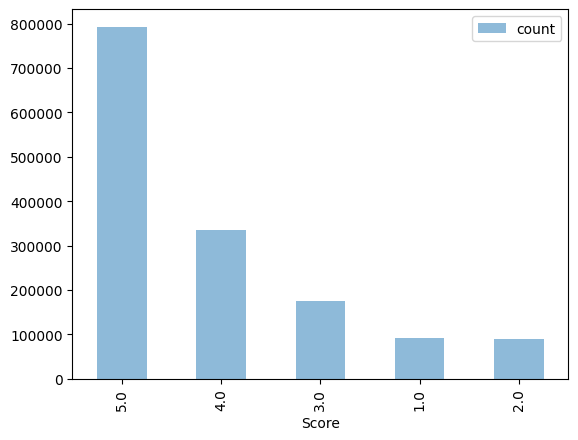


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

## Undersampling ##

In [ ]:
trainingSet.isnull

In [6]:
trainingSet = trainingSet.dropna(subset=['Summary'])

Score
4.0    89676
5.0    89676
2.0    89676
3.0    89676
1.0    89676
Name: count, dtype: int64


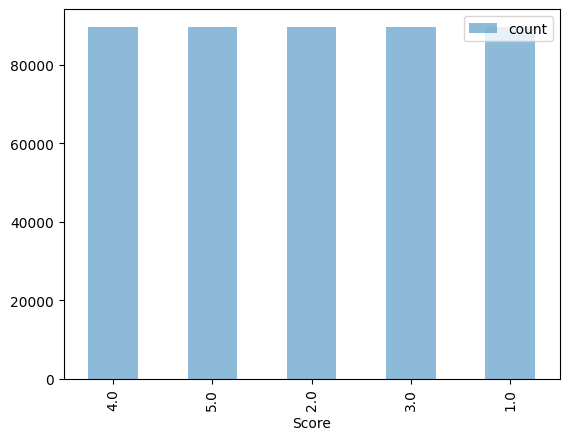

In [7]:
# Find the size of the minority class (smallest class)
minority_class_size = trainingSet['Score'].value_counts().min()

# Create an empty dataframe to hold the undersampled data
undersampled_df = pd.DataFrame()

# Iterate through each class in 'Score' column
for score in trainingSet['Score'].unique():
    # Get all instances of the current score
    class_df = trainingSet[trainingSet['Score'] == score]
    
    # If the class size is larger than the minority class size, apply undersampling
    if len(class_df) > minority_class_size:
        class_undersampled = resample(class_df, 
                                      replace=False,     # sample without replacement
                                      n_samples=minority_class_size,  # match minority class size
                                      random_state=42)   # reproducibility
    else:
        # If the class is already smaller than or equal to minority class size, keep it as is
        class_undersampled = class_df
    
    # Append the undersampled class (or original class) to the undersampled_df
    undersampled_df = pd.concat([undersampled_df, class_undersampled])

# Shuffle the combined undersampled dataframe
undersampled_df = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

undersampled_df = undersampled_df.drop(columns=['Id', 'UserId', 'ProductId'])

# Check the class distribution after undersampling
print(undersampled_df['Score'].value_counts())

# Plot the class distribution
undersampled_df['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()


## Preprocessing ##

In [8]:
# Drop missing values
undersampled_df.isnull().sum()  # Check for missing values
undersampled_df.dropna(subset=['Text'], inplace=True)  # Example of dropping rows with missing Text
undersampled_df = pd.merge(undersampled_df, )

# Convert timestamps
undersampled_df['Time'] = pd.to_datetime(undersampled_df['Time'], unit='s')  # Convert Unix timestamp to datetime
undersampled_df['Year'] = undersampled_df['Time'].dt.year  # Extract year from datetime

# Compute helpfulness ratio
undersampled_df['HelpfulnessRatio'] = undersampled_df['HelpfulnessNumerator'] / (undersampled_df['HelpfulnessDenominator'] + 1)

undersampled_df.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Score,Year,HelpfulnessRatio
0,1,4,2013-09-28,needs extras,"While this is a fine movie, this is really the...",4.0,2013,0.200000
1,0,0,2014-05-06,2 funny movies,Steve Martin is funny and in Housesitter him w...,4.0,2014,0.000000
2,0,0,2013-09-12,Gunsmoke,This DVD and other Gunsmoke DVD's was shipped ...,5.0,2013,0.000000
3,5,8,2000-12-26,Yawwnnnnnnnnnn,"This movie uhhhh, stunk. Period. Milla Jovovic...",2.0,2000,0.555556
4,4,9,2002-04-11,"Okay to watch once, then go back to Jesus of N...","This miniseries is good, but when you compare ...",3.0,2002,0.400000


# Text Preprocessing #

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer_text = TfidfVectorizer()
X_tfidf_text = tfidf_vectorizer_text.fit_transform(undersampled_df['Text'])

tfidf_vectorizer_summary = TfidfVectorizer()
X_tfidf_summary = tfidf_vectorizer_summary.fit_transform(undersampled_df['Summary'])



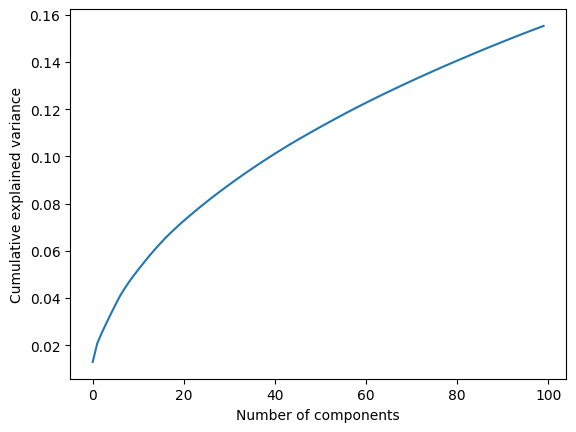

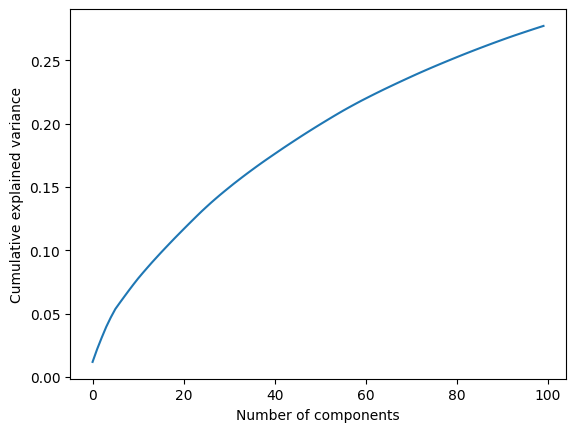

In [10]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# Apply Truncated SVD for dimensionality reduction
svd_text = TruncatedSVD(n_components=100, random_state=42)
X_reduced_text = svd_text.fit_transform(X_tfidf_text)

explained_variance_text = np.cumsum(svd_text.explained_variance_ratio_)

# Plot explained variance to decide how many components to keep
plt.plot(explained_variance_text)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

svd_summary = TruncatedSVD(n_components=100, random_state=42)
X_reduced_summary = svd_summary.fit_transform(X_tfidf_summary)

explained_variance_summary = np.cumsum(svd_summary.explained_variance_ratio_)

# Plot explained variance to decide how many components to keep
plt.plot(explained_variance_summary)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()



In [13]:
undersampled_df.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Score,Year,HelpfulnessRatio
0,1,4,2013-09-28,needs extras,"While this is a fine movie, this is really the...",4.0,2013,0.200000
1,0,0,2014-05-06,2 funny movies,Steve Martin is funny and in Housesitter him w...,4.0,2014,0.000000
2,0,0,2013-09-12,Gunsmoke,This DVD and other Gunsmoke DVD's was shipped ...,5.0,2013,0.000000
3,5,8,2000-12-26,Yawwnnnnnnnnnn,"This movie uhhhh, stunk. Period. Milla Jovovic...",2.0,2000,0.555556
4,4,9,2002-04-11,"Okay to watch once, then go back to Jesus of N...","This miniseries is good, but when you compare ...",3.0,2002,0.400000


In [25]:
X_svd_text_df = pd.DataFrame(X_reduced_text, columns=[f'SVD_text_feature_{i}' for i in range(1, 101)])
X_svd_summary_df = pd.DataFrame(X_reduced_summary, columns=[f'SVD_summary_feature_{i}' for i in range(1, 101)])
undersampled_df.reset_index(drop=True, inplace=True)
final_df = pd.concat([undersampled_df.drop(columns=['Text']), X_svd_text_df], axis=1)
final_df = pd.concat([final_df.drop(columns=['Summary']), X_svd_summary_df], axis=1)

# Extract year, month, day from Time
final_df['Year'] = final_df['Time'].dt.year
final_df['Month'] = final_df['Time'].dt.month
final_df['Day'] = final_df['Time'].dt.day

final_df['Year'] = final_df['Time'].dt.year
final_df['Month'] = final_df['Time'].dt.month
final_df['Day'] = final_df['Time'].dt.day

# Drop the original 'Time' column
final_df.drop(columns=['Time'], inplace=True)


# Check the new dataframe with added SVD features
final_df.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Year,HelpfulnessRatio,SVD_text_feature_1,SVD_text_feature_2,SVD_text_feature_3,SVD_text_feature_4,SVD_text_feature_5,...,SVD_summary_feature_93,SVD_summary_feature_94,SVD_summary_feature_95,SVD_summary_feature_96,SVD_summary_feature_97,SVD_summary_feature_98,SVD_summary_feature_99,SVD_summary_feature_100,Month,Day
0,1,4,4.0,2013,0.200000,0.293326,-0.086677,0.031292,0.014030,0.023713,...,-4.144469e-03,-6.222603e-03,-8.582014e-03,4.446481e-04,4.829131e-05,1.474650e-03,-1.193328e-03,-8.680400e-04,9,28
1,0,0,4.0,2014,0.000000,0.097555,-0.006485,-0.059603,-0.015784,-0.002176,...,-5.444670e-02,-3.465089e-03,-1.411718e-02,-4.630719e-02,-9.985099e-02,6.536951e-03,4.260603e-03,-1.051540e-02,5,6
2,0,0,5.0,2013,0.000000,0.136340,0.044508,0.015290,0.003454,0.022117,...,-5.962015e-05,1.860517e-04,3.099533e-05,-1.423375e-04,2.843692e-04,-1.024770e-04,2.937303e-05,-1.434264e-04,9,12
3,5,8,2.0,2000,0.555556,0.316291,-0.023922,0.046001,0.183545,-0.018095,...,-4.992847e-17,-5.260976e-17,-7.734404e-17,-9.465962e-17,-4.573566e-17,-8.491921e-17,-5.661292e-17,1.745713e-17,12,26
4,4,9,3.0,2002,0.400000,0.233803,0.059018,0.004547,-0.003334,0.008697,...,-1.091121e-02,-2.814606e-02,3.104629e-02,4.191660e-03,4.768560e-03,-2.226927e-03,-6.361753e-03,1.079633e-02,4,11


In [26]:
X = final_df.drop(columns=['Score'])
y = final_df['Score']
X_train, X_test, y_train, y_test = train_test_split(
    final_df.drop(columns=['Score']),
    final_df['Score'],
    test_size=1/4.0,
    random_state=0
)


In [27]:
# Convert data into DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Map your labels (y_train and y_test) to a 0-based index
y_train = y_train - 1
y_test = y_test - 1

# Convert data into DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train an XGBoost classifier
params = {'objective': 'multi:softmax', 'num_class': len(y_train.unique()), 'seed': 42}
model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions and evaluate accuracy
y_pred = model.predict(dtest)


# Train an XGBoost classifier
params = {'objective': 'multi:softmax', 'num_class': len(y.unique()), 'seed': 42}
model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions and evaluate accuracy
y_pred = model.predict(dtest)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.531456865019181


In [28]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import xgboost as xgb

# Define the parameter grid for XGBoost
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2],
    'n_estimators': [100, 200, 300],  # Same as num_boost_round
}

# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=len(y_train.unique()), seed=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_clf,
                                   param_distributions=param_grid,
                                   n_iter=20,  # Number of parameter combinations to try
                                   scoring='accuracy',  # Evaluation metric
                                   cv=3,  # 3-fold cross-validation
                                   verbose=1,
                                   random_state=42)

# Fit RandomizedSearchCV to the data
random_search.fit(X_train, y_train)

# Get the best parameters
print(f"Best Parameters: {random_search.best_params_}")

# Evaluate on the test set
y_pred = random_search.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 0.6, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}
Accuracy: 0.5403425818538674


Accuracy on testing set =  0.5403425818538674


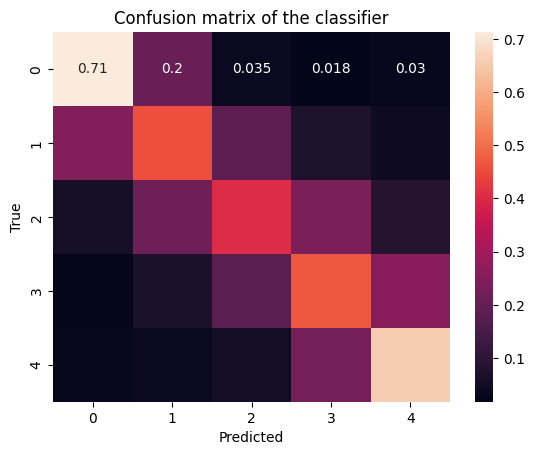

In [32]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(y_test, y_pred))

# Plot a confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()